In [ ]:
#Imports coordinates from a geojson file
import json
from types import SimpleNamespace

f = open('/home/nacho/Desktop/data/STREETS_NAV/SREETS_NAV_4815075.geojson')

content = f.read()

py_obj = json.loads(content, object_hook=lambda d: SimpleNamespace(**d))
print(py_obj.features[0].geometry.coordinates)

[[-99.63067, 19.26921], [-99.63059, 19.26927], [-99.63054, 19.27009], [-99.63052, 19.27025], [-99.63043, 19.27081]]


[[-99.63061, 19.26962], [-99.63062, 19.26989], [-99.63057, 19.27038], [-99.63055, 19.27052], [-99.63048, 19.27084], [-99.63044, 19.27106], [-99.63042, 19.2712]]


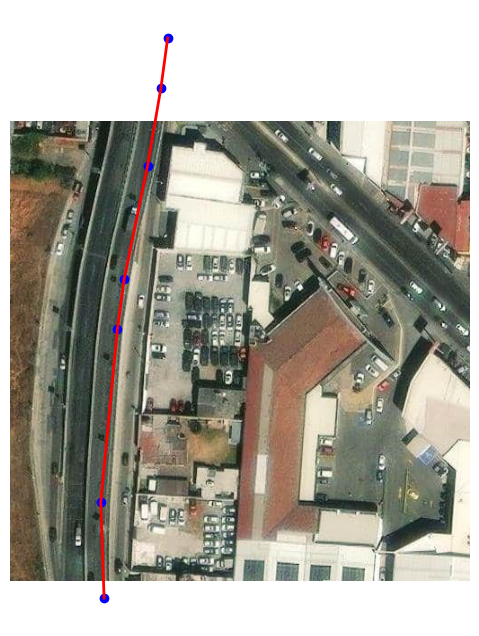

In [ ]:
# Imports coordinates from a geojson file
import json
from types import SimpleNamespace
import requests
import math
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Function to convert latitude and longitude to tile indices
def lat_lon_to_tile(lat, lon, zoom):
    n = 2.0 ** zoom
    x = (lon + 180.0) / 360.0 * n
    y = (1.0 - math.log(math.tan(math.radians(lat)) + 1.0 / math.cos(math.radians(lat))) / math.pi) / 2.0 * n
    return int(x), int(y)

# Function to convert latitude and longitude to pixel positions within a tile
def lat_lon_to_pixel(lat, lon, zoom, tile_size):
    n = 2.0 ** zoom
    x = (lon + 180.0) / 360.0 * n * tile_size
    y = (1.0 - math.log(math.tan(math.radians(lat)) + 1.0 / math.cos(math.radians(lat))) / math.pi) / 2.0 * n * tile_size
    return x, y

# Function to download the satellite image
def get_satellite_image(lat, lon, zoom, tile_size, tile_format, api_key):
    tile_x, tile_y = lat_lon_to_tile(lat, lon, zoom)
    url = f'https://maps.hereapi.com/v3/base/mc/{zoom}/{tile_x}/{tile_y}/{tile_format}?style=satellite.day&size={tile_size}&apiKey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content)), tile_x, tile_y
    else:
        raise Exception(f"Failed to retrieve tile. Status code: {response.status_code}")

# Function to adjust coordinates relative to the tile
def adjust_coords_to_tile(lat, lon, zoom, tile_size, tile_x, tile_y):
    pixel_x, pixel_y = lat_lon_to_pixel(lat, lon, zoom, tile_size)
    tile_origin_x = tile_x * tile_size
    tile_origin_y = tile_y * tile_size
    return pixel_x - tile_origin_x, pixel_y - tile_origin_y

# Define parameters
api_key = '376xUn1eTcHS5TgRBB9ahgKo914GUvRfpzR_pptCmPE'

# Coordinates for the line
f = open('/home/nacho/Desktop/data/STREETS_NAV/SREETS_NAV_4815075.geojson')

content = f.read()

py_obj = json.loads(content, object_hook=lambda d: SimpleNamespace(**d))
line_coords = py_obj.features[8].geometry.coordinates
print(line_coords)

# Use the middle coordinate as the center for the satellite image
middle_index = len(line_coords) // 2
latitude, longitude = line_coords[middle_index][1], line_coords[middle_index][0]
zoom_level = 18
tile_size = 512
tile_format = 'png'

# Get the satellite image and tile indices
satellite_image, tile_x, tile_y = get_satellite_image(latitude, longitude, zoom_level, tile_size, tile_format, api_key)

# Adjust all line coordinates to the tile
line_pixels = [adjust_coords_to_tile(lat, lon, zoom_level, tile_size, tile_x, tile_y) for lon, lat in line_coords]

# Plot the image and the lines
plt.figure(figsize=(8, 8))
plt.imshow(satellite_image)

# Plot the lines by connecting the points
x_coords, y_coords = zip(*line_pixels)
plt.plot(x_coords, y_coords, color='red', linewidth=2)  # Draw the line in red
plt.scatter(x_coords, y_coords, color='blue')  # Mark the points

# Display the map
plt.axis('off')
plt.show()